#### MNIST PCA

In [16]:
import numpy as np 
import pandas as pd 
import random as rn

# Visualization libraries
import pydotplus
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
from catboost import CatBoostClassifier

In [3]:
path = './data'

In [4]:
train_df= pd.read_csv(path + '/mnist_train.csv')
test_df= pd.read_csv(path + '/mnist_test.csv')

X_train = train_df.iloc[:,1:]
y_train = train_df.iloc[:,0]

X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]

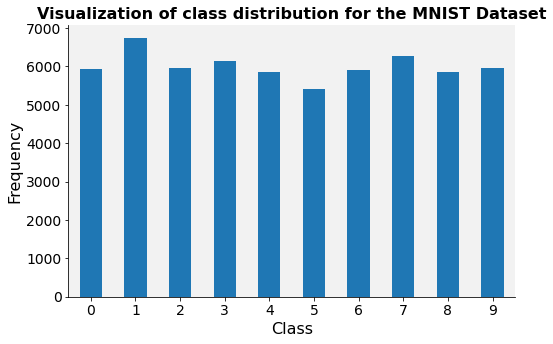

In [5]:


# Visualize target distribution
train_df['label'].value_counts().sort_index().plot(kind='bar', figsize=(8, 5), rot=0)
plt.title('Visualization of class distribution for the MNIST Dataset', fontsize=16, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
sns.despine()
plt.show()



/home/emserdev/.virtualenvs/DIPLO/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  after removing the cwd from sys.path.


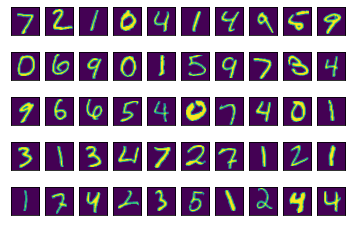

In [106]:
def show_images(num_images):
    if num_images % 10 == 0 and num_images <= 100:
        for digit_num in range(0,num_images): 
            plt.subplot(num_images/10,10,digit_num+1) #create subplots
            mat_data = X_test.iloc[digit_num].values.reshape(28,28)  #reshape images
            plt.imshow(mat_data) #plot the data
            plt.xticks([]) #removes numbered labels on x-axis
            plt.yticks([]) #removes numbered labels on y-axis
show_images(50)


In [96]:
def show_images_by_digit(digit_to_see):
    if digit_to_see in list(range(10)):
        indices = np.where(y_test == digit_to_see) # pull indices for num of interest
        for digit_num in range(0,50): 
            plt.subplot(5,10, digit_num+1) #create subplots
            #reshape images
            mat_data = X_test.iloc[indices[0][digit_num]].values.reshape(28,28)
            plt.imshow(mat_data) #plot the data
            plt.xticks([]) #removes numbered labels on x-axis
            plt.yticks([]) #removes numbered labels on y-axis


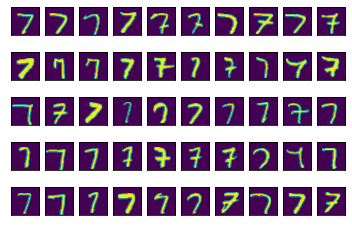

In [105]:
show_images_by_digit(7)

In [9]:
def get_pca(n_components, data):
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [73]:
def fit_classifier(X, y, print_conf_matrix_output=True):
    
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=42)

    model = CatBoostClassifier(
        iterations=1500,
        early_stopping_rounds= 30, #overfitting detector
        random_seed=42, )

    model.fit(X_train_clf,y_train_clf, 
              verbose=50,
              plot=False, 
              eval_set=(X_test_clf, y_test_clf), 
             )

    y_preds = model.predict(X_test_clf)

    acc = accuracy_score(y_test_clf, y_preds)
    
    if print_conf_matrix_output == True:
        
        model.tree_count_
        
        mat = confusion_matrix(y_test_clf, y_preds)
        sns.heatmap(mat, annot=True, linewidths=.5)

        print('Input Shape: {}'.format(X_train_clf.shape))
        print('Accuracy: {:2.2%}\n'.format(acc))
        print(mat)
    
    return model

Learning rate set to 0.280797
0:	learn: 1.5792566	test: 1.5799664	best: 1.5799664 (0)	total: 1.23s	remaining: 2m 1s
50:	learn: 0.1724185	test: 0.2013817	best: 0.2013817 (50)	total: 1m 25s	remaining: 1m 22s
99:	learn: 0.1372209	test: 0.1700538	best: 0.1700538 (99)	total: 2m 37s	remaining: 0us

bestTest = 0.1700538079
bestIteration = 99

Input Shape: (45000, 784)
Accuracy: 95.32%

[[1456    1    1    3    5    4   10    4   10    1]
 [   0 1621    9    5    2    0    3    5    1    3]
 [   9   11 1399   10    4    1    6   15   12    4]
 [   4    5   28 1399    0   32    3   14   21   12]
 [   1    4    2    1 1388    0    5    5    2   35]
 [   7    5    4   18    5 1311   11    3   11    8]
 [   7    0    5    0   10   12 1441    1    6    0]
 [   3   12   21    9   11    0    0 1552    6   21]
 [   5    7   10   22   12    8   12    3 1350   16]
 [   4    3    6   15   28    6    2   25    9 1381]]


0.9532

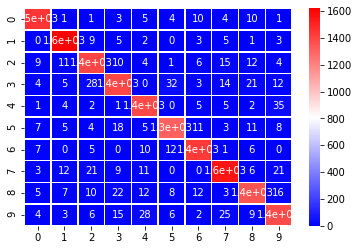

In [17]:
fit_classifier(X_train, y_train)

Linea base son reducción de dimensiones

Learning rate set to 0.280797
0:	learn: 1.9877880	test: 1.9901841	best: 1.9901841 (0)	total: 37.7ms	remaining: 3.73s
50:	learn: 1.6241053	test: 1.6463581	best: 1.6463503 (48)	total: 1.75s	remaining: 1.69s
99:	learn: 1.6072638	test: 1.6443142	best: 1.6438807 (78)	total: 3.43s	remaining: 0us

bestTest = 1.643880675
bestIteration = 78

Shrink model to first 79 iterations.
Input Shape: (45000, 2)
Accuracy: 35.78%

[[1006    0  262   19    8   30  154    0   16    0]
 [   0 1461    4    4    4   43   21   33   16   63]
 [ 181    3  626  145   82   29  267   28   49   61]
 [  51   19  361  144  122  110  287  129  123  172]
 [  28   73  287  119  134   52  269  135   76  270]
 [  43   23  295   95   71  317  342   13  134   50]
 [ 176   51  379   53   28  219  481   10   80    5]
 [   3  129   74   81  119   42  111  614   80  382]
 [  35   77  215  110   93  260  263   58  189  145]
 [   8  196   91   91  114   32  143  344   65  395]]


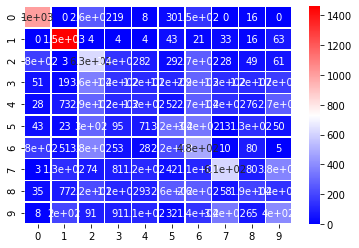

In [19]:
pca, X_pca = get_pca(2, X_train)
fit_classifier(X_pca, y_train);

In [20]:
def plot_components(X, y):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(10, 6))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), 
                 color=plt.cm.Set1(y[i]), 
                 fontdict={'size': 15})

    plt.xticks([]), plt.yticks([]), plt.ylim([-0.1,1.1]), plt.xlim([-0.1,1.1])


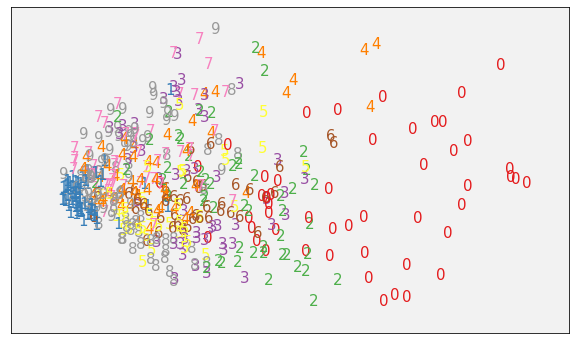

In [22]:
plot_components(X_pca[:500], y_train[:500])

In [24]:
acc_list, pc_list = [], []
for pc in range(2,40):
    pca, X_pca = get_pca(pc, X_train)
    acc = fit_classifier(X_pca, y_train, print_conf_matrix_output=False);
    acc_list.append(acc)
    pc_list.append(pc)

Learning rate set to 0.280797
0:	learn: 1.9878291	test: 1.9901275	best: 1.9901275 (0)	total: 30.3ms	remaining: 3s
50:	learn: 1.6235737	test: 1.6461875	best: 1.6461875 (50)	total: 1.76s	remaining: 1.69s
99:	learn: 1.6067146	test: 1.6452753	best: 1.6446797 (90)	total: 3.2s	remaining: 0us

bestTest = 1.644679724
bestIteration = 90

Shrink model to first 91 iterations.
Learning rate set to 0.280797
0:	learn: 1.7823794	test: 1.7860403	best: 1.7860403 (0)	total: 36.7ms	remaining: 3.64s
50:	learn: 1.1199958	test: 1.1490682	best: 1.1490682 (50)	total: 1.86s	remaining: 1.79s
99:	learn: 1.0910059	test: 1.1385348	best: 1.1385348 (99)	total: 3.73s	remaining: 0us

bestTest = 1.138534771
bestIteration = 99

Learning rate set to 0.280797
0:	learn: 1.6247570	test: 1.6266345	best: 1.6266345 (0)	total: 46.3ms	remaining: 4.58s
50:	learn: 0.7953190	test: 0.8321742	best: 0.8321742 (50)	total: 1.94s	remaining: 1.86s
99:	learn: 0.7514724	test: 0.8110684	best: 0.8110684 (99)	total: 3.91s	remaining: 0us

bestT

50:	learn: 0.2384903	test: 0.2706437	best: 0.2706437 (50)	total: 6.54s	remaining: 6.28s
99:	learn: 0.1627809	test: 0.2118532	best: 0.2118532 (99)	total: 13s	remaining: 0us

bestTest = 0.2118532332
bestIteration = 99

Learning rate set to 0.280797
0:	learn: 1.5433953	test: 1.5475054	best: 1.5475054 (0)	total: 138ms	remaining: 13.7s
50:	learn: 0.2312159	test: 0.2601160	best: 0.2601160 (50)	total: 5.71s	remaining: 5.49s
99:	learn: 0.1590483	test: 0.2048792	best: 0.2048792 (99)	total: 11.3s	remaining: 0us

bestTest = 0.2048792142
bestIteration = 99

Learning rate set to 0.280797
0:	learn: 1.5038801	test: 1.5083202	best: 1.5083202 (0)	total: 196ms	remaining: 19.4s
50:	learn: 0.2313803	test: 0.2619957	best: 0.2619957 (50)	total: 6.33s	remaining: 6.09s
99:	learn: 0.1590391	test: 0.2065405	best: 0.2065405 (99)	total: 12s	remaining: 0us

bestTest = 0.2065405437
bestIteration = 99

Learning rate set to 0.280797
0:	learn: 1.5259133	test: 1.5309947	best: 1.5309947 (0)	total: 126ms	remaining: 12.4s

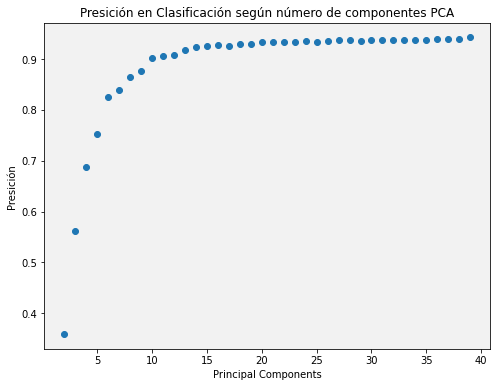

In [27]:
plt.figure(figsize=[8,6])
plt.scatter(pc_list, acc_list)
plt.title('Presición en Clasificación según número de componentes PCA')
plt.xlabel('Principal Components')
plt.ylabel('Presición');

In [28]:
np.max(acc_list), pc_list[np.where(acc_list == np.max(acc_list))[0][0]]

(0.9425333333333333, 39)

In [36]:
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(round(vals[i]*100,1))[:3])), (ind[i]+0.2, vals[i]), 
                    va="bottom", 
                    ha="center", 
                    fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1, length=6)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

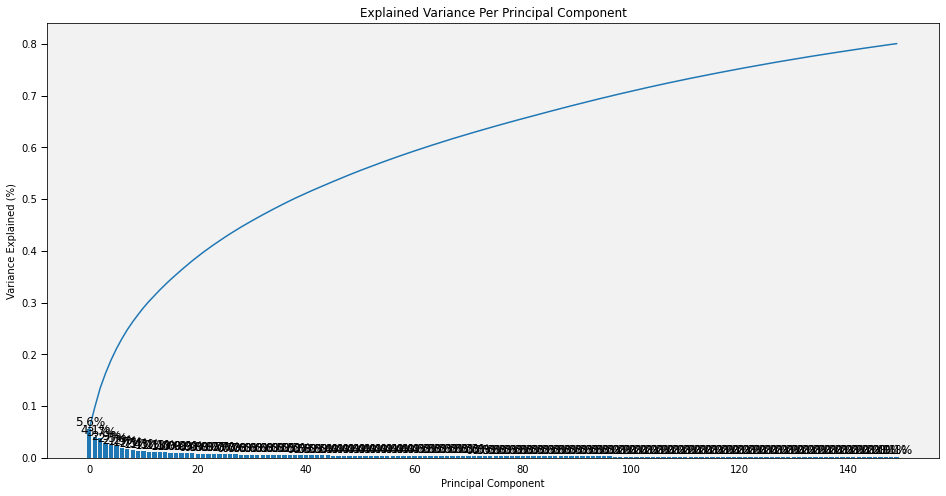

In [67]:
scree_plot(pca)

In [38]:
def plot_component(pca, comp):
    if comp <= len(pca.components_):
        mat_data = np.asmatrix(pca.components_[comp]).reshape(28,28)  #reshape images
        plt.imshow(mat_data); #plot the data
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis   

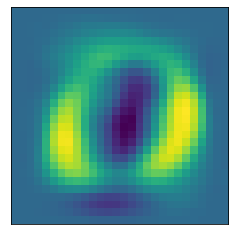

In [72]:
plot_component(pca,0)

In [61]:
pca, X_pca = get_pca(150, X_train)

Learning rate set to 0.099799
0:	learn: 1.9785929	test: 1.9798277	best: 1.9798277 (0)	total: 495ms	remaining: 12m 22s
50:	learn: 0.4332717	test: 0.4500322	best: 0.4500322 (50)	total: 31.9s	remaining: 15m 7s
100:	learn: 0.2716498	test: 0.2991487	best: 0.2991487 (100)	total: 1m 2s	remaining: 14m 28s
150:	learn: 0.2064832	test: 0.2425168	best: 0.2425168 (150)	total: 1m 33s	remaining: 13m 54s
200:	learn: 0.1697661	test: 0.2134546	best: 0.2134546 (200)	total: 2m 1s	remaining: 13m 2s
250:	learn: 0.1465757	test: 0.1960918	best: 0.1960918 (250)	total: 2m 29s	remaining: 12m 25s
300:	learn: 0.1296646	test: 0.1842555	best: 0.1842555 (300)	total: 3m 3s	remaining: 12m 9s
350:	learn: 0.1157572	test: 0.1747557	best: 0.1747557 (350)	total: 3m 33s	remaining: 11m 39s
400:	learn: 0.1034701	test: 0.1661947	best: 0.1661947 (400)	total: 4m 11s	remaining: 11m 28s
450:	learn: 0.0943149	test: 0.1600965	best: 0.1600965 (450)	total: 4m 46s	remaining: 11m 7s
500:	learn: 0.0862705	test: 0.1547899	best: 0.1547899 (

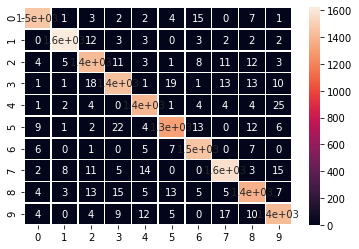

In [74]:
model = fit_classifier(X_pca,y_train )

In [75]:
model.tree_count_

1500

In [92]:
model.get_param('loss_function')

In [102]:
pca_test, X_pca_test = get_pca(150, X_test)

In [108]:
model.predict(X_pca_test)[2]

array([1])

In [110]:
model.predict_proba(X_pca_test)[0]

array([3.44523626e-05, 3.43792215e-05, 3.07779582e-03, 3.23623651e-03,
       6.23634015e-05, 2.91576301e-04, 2.95795643e-05, 9.87971061e-01,
       1.65712960e-03, 3.60542671e-03])